<a href="https://colab.research.google.com/github/fathanzys/NLP-Fathan/blob/main/Copy_of_uas_NLP_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deteksi Berita Palsu Berbasis Judul Menggunakan Pendekatan Multi-Model: TF-IDF, LSTM-GloVe, dan Tiny-BERT**

#Objective
Tujuan dari proyek ini adalah membangun sistem klasifikasi yang mampu mendeteksi berita palsu (fake news) hanya berdasarkan teks judul berita. Dengan menggunakan pendekatan machine learning dan deep learning, sistem ini diharapkan dapat mengidentifikasi apakah suatu berita bersifat nyata (real) atau palsu (fake) tanpa membaca isi artikelnya secara keseluruhan.

#Research Question
1. Sejauh mana model supervised learning seperti Logistic Regression dan Naive Bayes dapat mendeteksi fake news hanya dari judul berita?

2. Apakah penggunaan word embeddings (GloVe) dan model LSTM mampu meningkatkan akurasi klasifikasi dibandingkan metode klasik?

3. Seberapa efektif model transformer pralatih seperti Tiny-BERT jika difine-tune untuk tugas klasifikasi fake news?

#Datasets
Dataset terdiri dari dua file CSV, yaitu True-News.csv dan Fake-News.csv. Kedua dataset berisi kolom title (judul berita), kemudian diberi label: 1 untuk berita nyata dan 0 untuk berita palsu. Dataset digabung, diacak, dan dibagi secara stratified menjadi data pelatihan dan pengujian dengan rasio 80:20.

#Methods
Proyek ini mencakup beberapa tahap:

1. Praproses Teks: konversi ke huruf kecil, penghapusan angka dan karakter khusus, stemming, dan penghapusan stopwords.

2. Representasi Fitur: TF-IDF untuk baseline klasik, Tokenizer + Padding untuk LSTM, dan tokenisasi khusus BERT untuk Tiny-BERT.

#Model:
1. Logistic Regression,
2. Naive Bayes,
3. LinearSVC (TF-IDF),
4. LSTM dengan GloVe 100D (deep learning),
5. Fine-tuning model Tiny-BERT (prajjwal1/bert-tiny) untuk klasifikasi.

#Baselines
Model baseline yang digunakan dalam eksperimen adalah:

1. TF-IDF + Logistic Regression

2. TF-IDF + Multinomial Naive Bayes

3. TF-IDF + LinearSVC
Ketiganya digunakan sebagai pembanding terhadap model deep learning seperti LSTM dan transformer seperti Tiny-BERT.

#Evaluation
Evaluasi model dilakukan menggunakan metrik:

1. AUC (Area Under the ROC Curve) untuk mengukur performa klasifikasi secara keseluruhan

2. Classification Report: Precision, Recall, F1-Score

3. Confusion Matrix untuk melihat jumlah prediksi benar dan salah

4. ROC Curve untuk membandingkan performa masing-masing model secara visual
Visualisasi tambahan berupa WordCloud juga digunakan untuk menggambarkan kata-kata yang dominan muncul pada berita nyata dan palsu.

#**Install Library**

In [ ]:
!pip install -q nltk plotly wordcloud scikit-learn transformers

In [ ]:
!pip install -q tensorflow.keras

#**Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# NLP & Visualisasi
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# HuggingFace Transformers
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from transformers import AdamWeightDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#**1. Data Collection**

#Deskripsi
Pada tahap ini, dilakukan proses pengumpulan dan penggabungan data yang akan digunakan untuk membangun sistem deteksi berita palsu (fake news detection). Data yang digunakan terdiri dari dua bagian utama: berita asli (true) dan berita palsu (fake), masing-masing berasal dari file terpisah.

Tujuan dari section ini adalah untuk:
- Memuat dataset dari penyimpanan lokal/Google Drive
- Memberikan label klasifikasi biner (1 = berita asli, 0 = berita palsu)
- Menggabungkan dan mengacak data agar distribusi tidak bias terhadap urutan
- Melakukan eksplorasi awal terhadap jumlah data pada tiap kelas

Tahap ini sangat krusial untuk memastikan bahwa data yang akan digunakan pada proses training dan evaluasi sudah terstruktur dengan benar.

###**1.1 Dataset Overview**

#Deskripsi
Bagian ini memuat dua dataset utama yang terdiri dari judul berita asli dan palsu. Setiap berita diberi label: 1 untuk real news dan 0 untuk fake news. Kedua dataset kemudian digabung dan diacak untuk memastikan distribusi yang acak dan tidak bias.

Langkah ini diperlukan untuk menyatukan sumber data dan menjadikannya dalam format yang siap untuk proses pra-pemrosesan dan pelatihan model.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
true_news = pd.read_csv('/content/True-News.csv')
fake_news = pd.read_csv('/content/Fake-News.csv')

In [ ]:
# Tambahkan label
df_true = pd.DataFrame({'title': true_news['title'], 'label': 1})
df_fake = pd.DataFrame({'title': fake_news['title'], 'label': 0})

In [ ]:
df = pd.concat([df_true, df_fake]).sample(frac=1.0, random_state=42).reset_index(drop=True)
df.head()

,title,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,0
1,Failed GOP Candidates Remembered In Hilarious...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,0
3,California AG pledges to defend birth control ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,0


###**1.2 Distribusi Label**

#Deskripsi
Subbagian ini berfungsi untuk menampilkan distribusi jumlah label dalam dataset. Analisis dilakukan dengan menghitung jumlah masing-masing kelas dan memvisualisasikannya menggunakan histogram.

Hal ini penting untuk mengetahui apakah data yang digunakan seimbang (balanced) atau tidak, karena ketidakseimbangan kelas dapat mempengaruhi performa model klasifikasi dan membutuhkan penanganan khusus seperti oversampling atau teknik penyeimbangan lainnya.


label
0    23481
1    21417
Name: count, dtype: int64


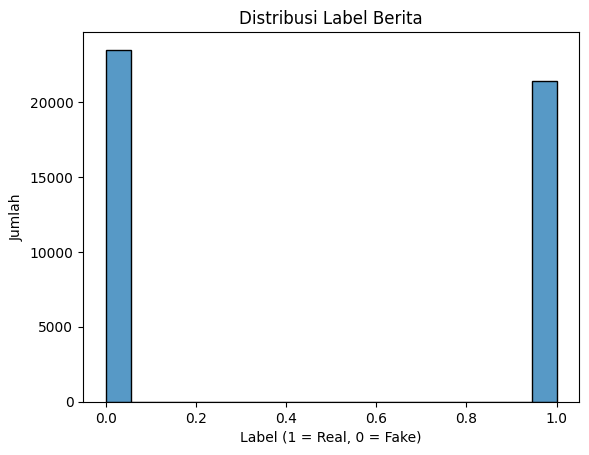

In [ ]:
print(df['label'].value_counts())
sns.histplot(df['label'], kde=False)
plt.title("Distribusi Label Berita")
plt.xlabel("Label (1 = Real, 0 = Fake)")
plt.ylabel("Jumlah")
plt.show()

#**2. Data Pre-Processing**

#Deskripsi
Tahap ini bertujuan untuk membersihkan dan menyiapkan data teks agar dapat diproses lebih lanjut dalam ekstraksi fitur dan pelatihan model.

Pada tahap ini dilakukan pembersihan teks mentah dari karakter atau simbol yang tidak relevan, normalisasi, penghapusan kata-kata umum (stopwords), dan stemming. Kemudian dilakukan juga visualisasi menggunakan WordCloud untuk melihat representasi kata paling sering muncul dalam berita palsu dan asli.

Pra-pemrosesan sangat penting untuk meningkatkan kualitas fitur yang diekstraksi dari data teks dan membantu model belajar pola yang lebih baik.

###**2.1 Text Cleaning**

#Deskripsi
Subbagian ini berisi fungsi `preprocess()` yang bertugas membersihkan teks dari karakter khusus, mengubah teks menjadi huruf kecil, menghapus angka dan simbol, serta melakukan stemming dan stopword removal.

Proses ini bertujuan untuk menstandarkan teks, mengurangi noise, dan menyederhanakan kata-kata ke bentuk dasarnya agar dapat memperkuat representasi fitur pada tahap selanjutnya.

In [ ]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\$[^\s]+', 'dollar', text)
    text = re.sub(r'\d+', 'number', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [ps.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_title'] = df['title'].astype(str).apply(preprocess)
df[['title', 'clean_title']].head()

,title,clean_title
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,break gop chairman grassley enough demand trum...
1,Failed GOP Candidates Remembered In Hilarious...,fail gop candid rememb hilari mock eulog video
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,mike penc new dc neighbor hilari troll homopho...
3,California AG pledges to defend birth control ...,california ag pledg defend birth control insur...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,az rancher live usmexico border destroy nanci ...


###**2.1 Wordcloud Visualization**

#Deskripsi

Subbagian ini menghasilkan visualisasi WordCloud untuk kata-kata yang paling sering muncul dalam berita asli dan berita palsu setelah dilakukan pembersihan teks.

Visualisasi ini membantu memahami secara eksploratif kata-kata dominan pada masing-masing kelas, dan dapat memberikan insight awal tentang perbedaan kosakata yang mungkin digunakan dalam fake news dan real news.

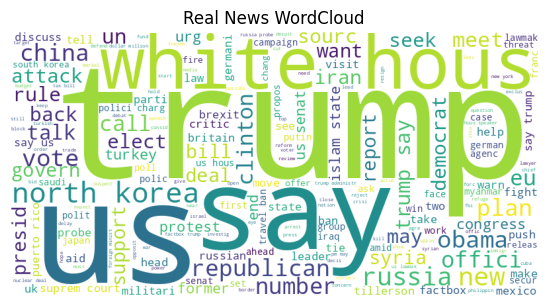

In [ ]:
real_titles = ' '.join(df[df.label == 1]['clean_title'])
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_titles)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(wc_real); plt.axis('off'); plt.title("Real News WordCloud")
plt.show()

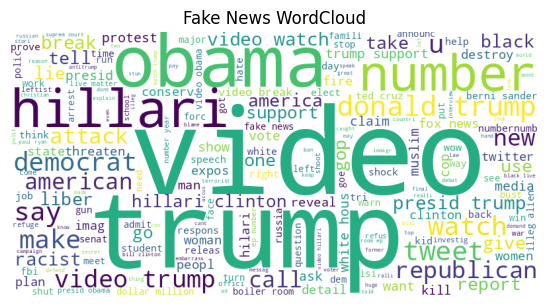

In [ ]:
fake_titles = ' '.join(df[df.label == 0]['clean_title'])
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_titles)

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.imshow(wc_fake); plt.axis('off'); plt.title("Fake News WordCloud")
plt.show()

#**3. Feature Representation**

#Deskripsi

Tahap ini bertujuan untuk mengubah teks menjadi bentuk numerik yang dapat diproses oleh algoritma Machine Learning maupun Deep Learning.

Pada bagian ini digunakan dua pendekatan utama: TF-IDF untuk model machine learning konvensional, dan Tokenizer + Padding untuk model deep learning seperti LSTM. Representasi fitur sangat penting untuk memetakan kata/kalimat menjadi vektor numerik agar model bisa memahami dan mempelajari pola dari teks.

###**3.1 TF-IDF**

#Deskripsi

Bagian ini menerapkan teknik TF-IDF (Term Frequency - Inverse Document Frequency) untuk mengubah teks menjadi representasi vektor yang mempertimbangkan pentingnya kata di suatu dokumen relatif terhadap seluruh koleksi dokumen.

TF-IDF digunakan sebagai input utama untuk model baseline machine learning seperti Logistic Regression, Naive Bayes, dan Linear SVC. Prosesnya dilakukan setelah data dibagi menjadi data latih dan uji agar tidak terjadi data leakage.

In [ ]:
# Before TF-IDF
X_text = df['clean_title']
y = df['label'].values
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=42)

# Apply TF-IDF after split
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

###**3.2 Tokenizer & Padding**

#Deskripsi

Subbagian ini digunakan untuk mempersiapkan input teks bagi model deep learning. Proses dimulai dengan Tokenizer dari Keras untuk mengubah kata menjadi indeks integer, dilanjutkan dengan Padding agar semua input memiliki panjang yang sama.

Representasi ini diperlukan untuk model seperti LSTM agar bisa memproses input secara berurutan dan konsisten. Tokenizer ha

In [ ]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(df['clean_title'], y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_dl)
word_index = tokenizer.word_index
X_train_seq = tokenizer.texts_to_sequences(X_train_dl)
X_test_seq = tokenizer.texts_to_sequences(X_test_dl)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

#**4. Model Development**

#Deskripsi

Pada tahap ini dilakukan pembangunan model klasifikasi untuk mendeteksi apakah suatu judul berita termasuk fake news atau real news. Tiga pendekatan digunakan:

1. Model baseline berbasis TF-IDF dan algoritma Machine Learning konvensional.
2. Model deep learning menggunakan LSTM dengan word embedding dari GloVe.
3. Model transformer Tiny-BERT yang ditransfer-learning dari pretrained language model.

Tujuan utamanya adalah membandingkan performa berbagai pendekatan berdasarkan kompleksitas dan akurasinya dalam mendeteksi fake news.

###**4.1 Baseline TF-IDF & Machine Learning Classifier**

#Deskripsi

Model baseline ini menggunakan representasi TF-IDF sebagai input untuk tiga model klasik: Logistic Regression, Multinomial Naive Bayes, dan Linear SVC.

Tujuannya adalah menyediakan pembanding awal (baseline) untuk performa deteksi berita palsu menggunakan pendekatan sederhana namun efektif. Hasil baseline ini nantinya akan dibandingkan dengan pendekatan LSTM dan Tiny-BERT.

In [ ]:
# Train baseline ML models with clean TF-IDF pipeline
nb = MultinomialNB().fit(X_train_tfidf, y_train)
logreg = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
svc = CalibratedClassifierCV(LinearSVC()).fit(X_train_tfidf, y_train)

###**4.2 LSTM & Global Vector Embeddings**

#Deskripsi

Bagian ini melatih model deep learning dengan arsitektur LSTM (Long Short-Term Memory) yang mampu menangkap dependensi urutan kata dalam teks.

Model ini menggunakan embedding GloVe (Global Vectors) untuk memberikan representasi kata yang lebih semantik. Embedding pre-trained digunakan agar model lebih cepat belajar dengan konteks yang telah dipelajari dari data besar.

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train_dl)
X_test_seq = tokenizer.texts_to_sequences(X_test_dl)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# # Download GloVe
!wget -O glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o -q glove.6B.zip

--2025-07-24 06:55:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-24 06:55:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-24 06:55:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Load GloVe
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, vector = values[0], np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [ ]:
# Arsitektur LSTM
inputs = Input(shape=(100,))
emb = Embedding(input_dim=len(word_index)+1, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False)(inputs)
x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(emb)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
lstm_model = Model(inputs, outputs)

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
history_lstm = lstm_model.fit(X_train_pad, y_train_dl, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 276s 587ms/step - accuracy: 0.8345 - auc: 0.9128 - loss: 0.3630 - val_accuracy: 0.8956 - val_auc: 0.9666 - val_loss: 0.2453
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 325s 602ms/step - accuracy: 0.9005 - auc: 0.9636 - loss: 0.2422 - val_accuracy: 0.9156 - val_auc: 0.9734 - val_loss: 0.2079
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 315s 589ms/step - accuracy: 0.9119 - auc: 0.9716 - loss: 0.2136 - val_accuracy: 0.9241 - val_auc: 0.9782 - val_loss: 0.1866
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 261s 580ms/step - accuracy: 0.9220 - auc: 0.9786 - loss: 0.1856 - val_accuracy: 0.9303 - val_auc: 0.9810 - val_loss: 0.1748
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 259s 575ms/step - accuracy: 0.8899 - auc: 0.9461 - loss: 0.3117 - val_accuracy: 0.9227 - val_auc: 0.9806 - val_loss: 0.1852
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 264s 581ms/step - accuracy: 0.9299 - auc: 0.9815 - loss: 0.1726 - val_accuracy: 0.9321 - val_auc: 0.9826 - val_loss: 0.1691
Epoch 7/10
449/4

###**4.3 Tiny-BERT Fine-Tuning**

#Deskripsi

Tiny-BERT adalah model transformer ringan yang ditraining ulang (fine-tuned) untuk tugas klasifikasi binary.

Langkah ini mencakup proses tokenisasi, encoding input, kompilasi model BERT, dan fine-tuning pada data deteksi berita palsu. Tiny-BERT dipilih karena ukurannya yang kecil namun tetap powerful, cocok untuk eksperimen efisien di lingkungan terbatas.

In [ ]:
# 1. Split data dulu (pindahkan ini ke paling atas di section 4.3)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df['clean_title'], y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 2. Tokenisasi
tokenizer_tiny = BertTokenizerFast.from_pretrained('prajjwal1/bert-tiny')
train_encodings = tokenizer_tiny(X_train_bert.tolist(), truncation=True, padding=True, max_length=64, return_tensors='np')
test_encodings = tokenizer_tiny(X_test_bert.tolist(), truncation=True, padding=True, max_length=64, return_tensors='np')

X_train_tiny = train_encodings['input_ids']
mask_train_tiny = train_encodings['attention_mask']
X_test_tiny = test_encodings['input_ids']
mask_test_tiny = test_encodings['attention_mask']

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [ ]:
# 3. Load model & compile
bert_tiny_model = TFBertForSequenceClassification.from_pretrained(
    'prajjwal1/bert-tiny',
    num_labels=2,
    from_pt=True)

optimizer_tiny = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
bert_tiny_model.compile(
    optimizer=optimizer_tiny,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should p

In [ ]:
# 4. Fine-tune model

# Split training data for validation
X_train_tiny_split, X_val_tiny_split, mask_train_tiny_split, mask_val_tiny_split, y_train_bert_split, y_val_bert_split = train_test_split(
    X_train_tiny, mask_train_tiny, y_train_bert, test_size=0.1, random_state=42, stratify=y_train_bert
)


# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_tiny_split, 'attention_mask': mask_train_tiny_split},
    y_train_bert_split
)).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

# Create TensorFlow datasets for validation
validation_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_val_tiny_split, 'attention_mask': mask_val_tiny_split},
    y_val_bert_split
)).batch(16).prefetch(tf.data.AUTOTUNE)

history_tiny = bert_tiny_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
2021/2021 [==============================] - 31s 15ms/step - loss: 0.0271 - accuracy: 0.9901 - val_loss: 0.1985 - val_accuracy: 0.9566
Epoch 2/10
2021/2021 [==============================] - 31s 15ms/step - loss: 0.0229 - accuracy: 0.9922 - val_loss: 0.1984 - val_accuracy: 0.9549
Epoch 3/10
2021/2021 [==============================] - 31s 16ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.2217 - val_accuracy: 0.9493
Epoch 4/10
2021/2021 [==============================] - 31s 15ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.2372 - val_accuracy: 0.9560
Epoch 5/10
2021/2021 [==============================] - 30s 15ms/step - loss: 0.0154 - accuracy: 0.9947 - val_loss: 0.2314 - val_accuracy: 0.9532
Epoch 6/10
2021/2021 [==============================] - 31s 15ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.2419 - val_accuracy: 0.9546
Epoch 7/10
2021/2021 [==============================] - 30s 15ms/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.2430 -

#**5. Evaluation Baseline ML & Transformer**

#Deskripsi

Bagian ini berfungsi untuk mengevaluasi kinerja seluruh model yang telah dilatih: Logistic Regression, Naive Bayes, Linear SVC, LSTM, dan Tiny-BERT.

Evaluasi dilakukan menggunakan metrik seperti AUC, confusion matrix, dan classification report agar dapat dibandingkan secara objektif berdasarkan akurasi, precision, recall, dan f1-score.

###**5.1 Baseline Evaluation**

#Deskripsi

Fungsi `evaluate()` digunakan untuk menghitung skor AUC dan menghasilkan classification report untuk masing-masing model baseline: Logistic Regression, Naive Bayes, dan Linear SVC.

AUC (Area Under Curve) digunakan karena cocok untuk evaluasi model binary classification, khususnya saat dataset tidak seimbang.

In [ ]:
# Function evaluasi
def evaluate(model, X, y_true, name):
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X)
        y_probs = (scores - scores.min()) / (scores.max() - scores.min())
    else:
        y_probs = model.predict(X).flatten()

    auc_score = roc_auc_score(y_true, y_probs)
    print(f"{name} AUC: {auc_score:.4f}")
    print(classification_report(y_true, y_probs > 0.5))
    return roc_curve(y_true, y_probs), auc_score

In [ ]:
# Evaluasi ulang baseline
(fpr_lr, tpr_lr, _), auc_lr = evaluate(logreg, X_test_tfidf, y_test, "Logistic Regression")

Logistic Regression AUC: 0.9857
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4696
           1       0.93      0.95      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [ ]:
(fpr_nb, tpr_nb, _), auc_nb = evaluate(nb, X_test_tfidf, y_test, "Naive Bayes")

Naive Bayes AUC: 0.9803
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4696
           1       0.93      0.91      0.92      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [ ]:
(fpr_svc, tpr_svc, _), auc_svc = evaluate(svc, X_test_tfidf, y_test, "Linear SVC")

Linear SVC AUC: 0.9880
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.94      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



###**5.2 Tiny-BERT & LSTM Evaluation**

#Deskripsi

Model LSTM dan Tiny-BERT dievaluasi dengan menghitung probabilitas prediksi, membuat ROC curve, dan menghitung AUC serta classification report.

Langkah ini membantu memahami bagaimana kinerja model berbasis deep learning dan transformer dibanding baseline klasik.

In [ ]:
# Tiny-BERT
logits_tiny = bert_tiny_model.predict({'input_ids': X_test_tiny, 'attention_mask': mask_test_tiny}).logits
y_probs_tiny = tf.nn.softmax(logits_tiny, axis=1)[:, 1].numpy()
y_pred_tiny = (y_probs_tiny > 0.5).astype(int)
auc_tiny = roc_auc_score(y_test_bert, y_probs_tiny)

# Classification Report Tiny-BERT
print("Classification Report - Tiny-BERT")
print(classification_report(y_test_bert, y_pred_tiny))

281/281 [==============================] - 2s 7ms/step
Classification Report - Tiny-BERT
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4696
           1       0.96      0.94      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [ ]:
# LSTM
y_probs_lstm = lstm_model.predict(X_test_pad).flatten()
(fpr_lstm, tpr_lstm, _) = roc_curve(y_test_dl, y_probs_lstm)
y_pred_lstm = (y_probs_lstm > 0.5).astype(int)
auc_lstm = roc_auc_score(y_test_dl, y_probs_lstm)

# Classification Report LSTM
print("Classification Report - LSTM")
print(classification_report(y_test_dl, y_pred_lstm))

281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step
Classification Report - LSTM
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4696
           1       0.91      0.95      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [ ]:
(fpr_tiny, tpr_tiny, _) = roc_curve(y_test_bert, y_probs_tiny)

#**6. Visualization**

#Deskripsi

Bagian ini menyajikan visualisasi dari performa model melalui Confusion Matrix dan ROC Curve.
Visualisasi membantu menganalisis kekuatan dan kelemahan masing-masing model dalam klasifikasi fake news.

Confusion Matrix menunjukkan jumlah kesalahan klasifikasi, sedangkan ROC Curve dan AUC memberi gambaran umum tentang kemampuan model membedakan antara kelas.

###**6.1 Confussion Matrix**

Subbagian ini menampilkan confusion matrix dari tiap model (Logistic Regression, Naive Bayes, Linear SVC, LSTM, dan Tiny-BERT).

Fungsi `plot_confusion_matrix` digunakan untuk menggambarkan perbandingan prediksi vs label aktual. Ini sangat membantu untuk menganalisis false positives dan false negatives.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

####**6.1.1 Logistic Regression**

#Deskripsi

Visualisasi confusion matrix untuk model Logistic Regression yang dilatih dengan TF-IDF.
Digunakan untuk mengevaluasi seberapa akurat model memprediksi label real/fake dan mendeteksi jenis kesalahan klasifikasi.

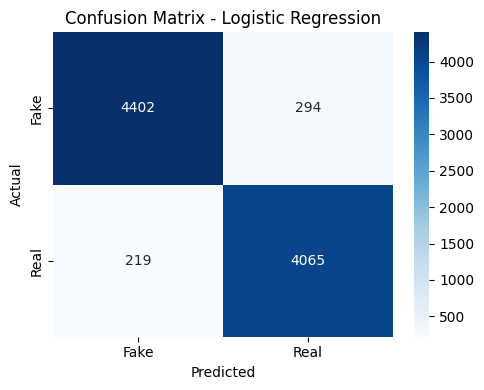

In [ ]:
# Logistic Regression
y_probs_lr = logreg.predict_proba(X_test_tfidf)[:, 1]
y_pred_lr = (y_probs_lr > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')

####**6.1.2 Naive Bayes**

#Deskripsi

Confusion matrix untuk model Naive Bayes menunjukkan kinerja klasifikasi berdasarkan jumlah prediksi benar dan salah.
Memberikan gambaran tentang kemampuan model berbasis probabilistik dalam membedakan berita nyata dan palsu.

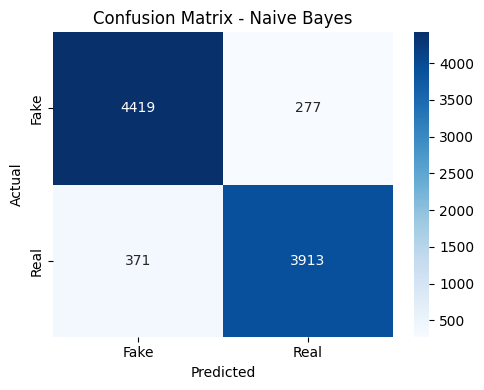

In [ ]:
# Naive Bayes
y_probs_nb = nb.predict_proba(X_test_tfidf)[:, 1]
y_pred_nb = (y_probs_nb > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_nb, 'Naive Bayes')

####**6.1.3 Linear SVC**

#Deskripsi

Menampilkan confusion matrix dari model Linear SVC (Support Vector Classifier) yang telah dikalibrasi.
Membantu memvisualisasikan kekuatan margin classifier dalam memisahkan dua kelas dengan TF-IDF.

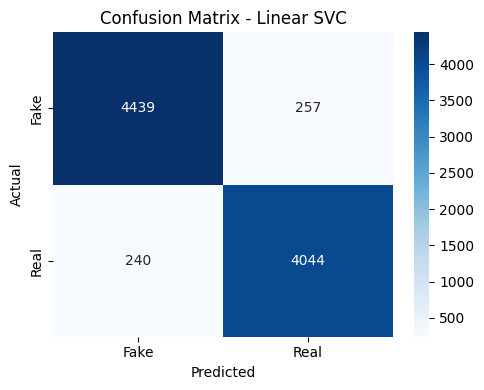

In [ ]:
# Linear SVC
y_probs_svc = svc.predict_proba(X_test_tfidf)[:, 1]
y_pred_svc = (y_probs_svc > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_svc, 'Linear SVC')

####**6.1.4 LSTM**

#Deskripsi

Confusion matrix untuk model LSTM yang dilatih dengan embedding GloVe.
Digunakan untuk mengevaluasi kemampuan model dalam memahami urutan kata dan konteks secara sekuensial pada data judul berita.

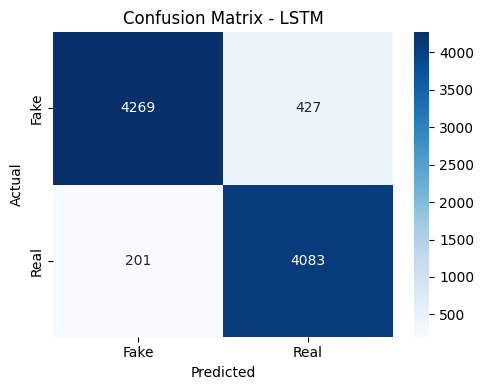

In [ ]:
# Prediksi label dari probabilitas LSTM
y_pred_lstm = (y_probs_lstm > 0.5).astype(int)

# Visualisasi Confusion Matrix LSTM
plot_confusion_matrix(y_test_dl, y_pred_lstm, 'LSTM')  # gunakan y_test_dl

####**6.1.5 Tiny-BERT**

#Deskripsi

Menampilkan hasil confusion matrix dari model Tiny-BERT.
Bertujuan untuk melihat efektivitas arsitektur transformer dalam mengklasifikasikan berita hanya dari judul dengan memahami konteks secara mendalam.

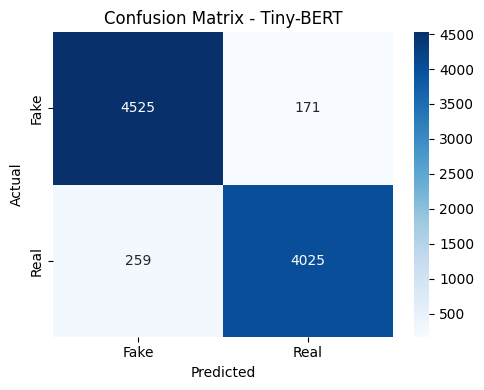

In [ ]:
# Prediksi label dari probabilitas Tiny-BERT
y_pred_tiny = (y_probs_tiny > 0.5).astype(int)

# Visualisasi Confusion Matrix Tiny-BERT
plot_confusion_matrix(y_test_bert, y_pred_tiny, 'Tiny-BERT')

###**6.2 ROC Visualization**

#Deskripsi

ROC Curve dari semua model divisualisasikan dalam satu grid agar mudah dibandingkan. Setiap kurva menunjukkan performa model berdasarkan AUC (Area Under Curve).

Semakin tinggi AUC, semakin baik model dalam membedakan antara kelas 'Real' dan 'Fake'.

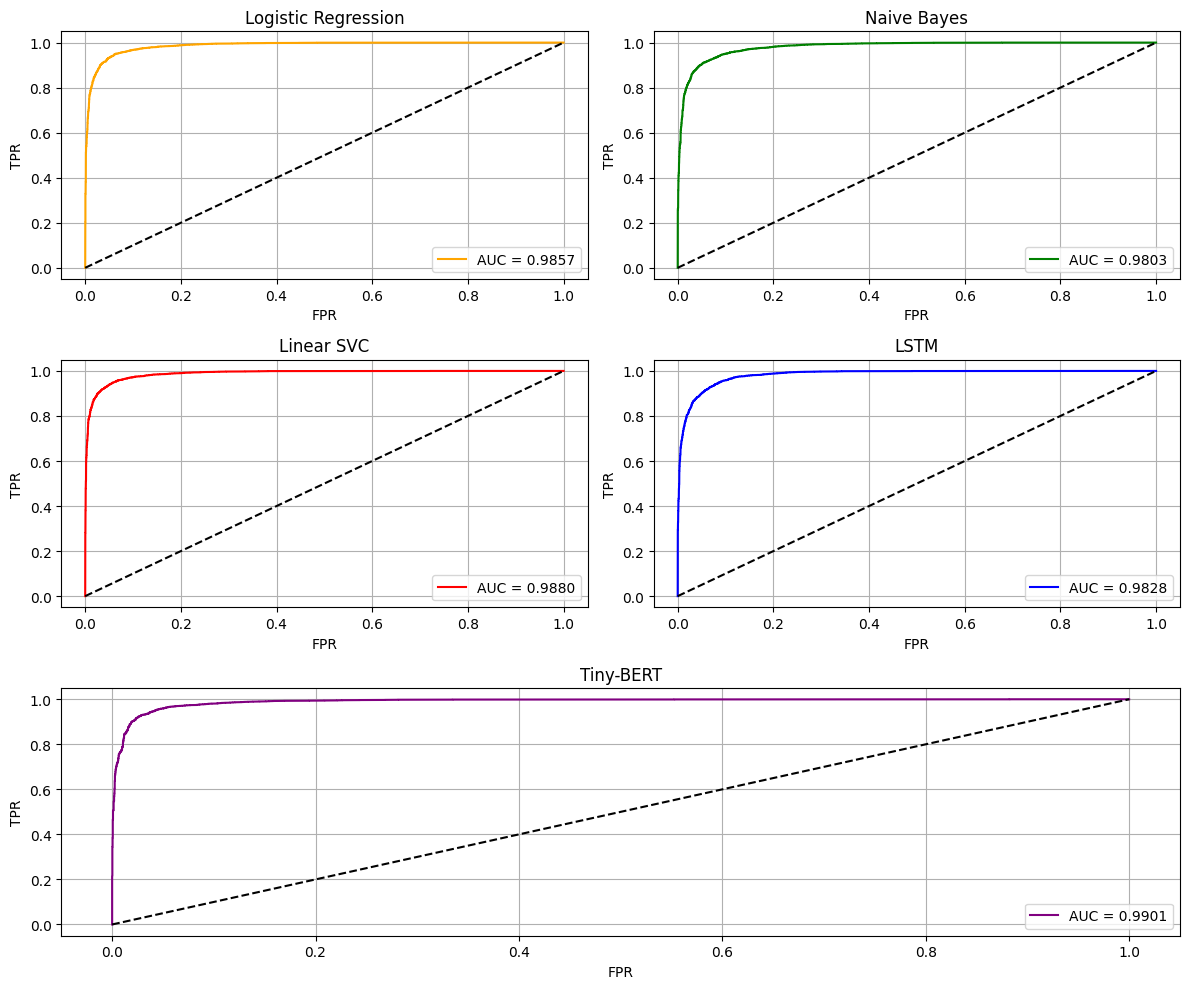

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# ROC - Logistic Regression
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(fpr_lr, tpr_lr, color='orange', label=f'AUC = {auc_lr:.4f}')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title("Logistic Regression")
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax1.legend()
ax1.grid()

# ROC - Naive Bayes
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(fpr_nb, tpr_nb, color='green', label=f'AUC = {auc_nb:.4f}')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_title("Naive Bayes")
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.legend()
ax2.grid()

# ROC - Linear SVC
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(fpr_svc, tpr_svc, color='red', label=f'AUC = {auc_svc:.4f}')
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_title("Linear SVC")
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")
ax3.legend()
ax3.grid()

# ROC - LSTM
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(fpr_lstm, tpr_lstm, color='blue', label=f'AUC = {auc_lstm:.4f}')
ax4.plot([0, 1], [0, 1], 'k--')
ax4.set_title("LSTM")
ax4.set_xlabel("FPR")
ax4.set_ylabel("TPR")
ax4.legend()
ax4.grid()

# ROC - Tiny-BERT
ax5 = fig.add_subplot(gs[2, :])
ax5.plot(fpr_tiny, tpr_tiny, color='purple', label=f'AUC = {auc_tiny:.4f}')
ax5.plot([0, 1], [0, 1], 'k--')
ax5.set_title("Tiny-BERT")
ax5.set_xlabel("FPR")
ax5.set_ylabel("TPR")
ax5.legend()
ax5.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Tambahkan ringkasan AUC
print(f"AUC Logistic Regression: {auc_lr:.4f}")
print(f"AUC Naive Bayes        : {auc_nb:.4f}")
print(f"AUC Linear SVC         : {auc_svc:.4f}")
print(f"AUC LSTM + GloVe       : {auc_lstm:.4f}")
print(f"AUC Tiny-BERT          : {auc_tiny:.4f}")

AUC Logistic Regression: 0.9857
AUC Naive Bayes        : 0.9803
AUC Linear SVC         : 0.9880
AUC LSTM + GloVe       : 0.9828
AUC Tiny-BERT          : 0.9901


##**6.3 Grafik**

###**6.3.1 LSTM**

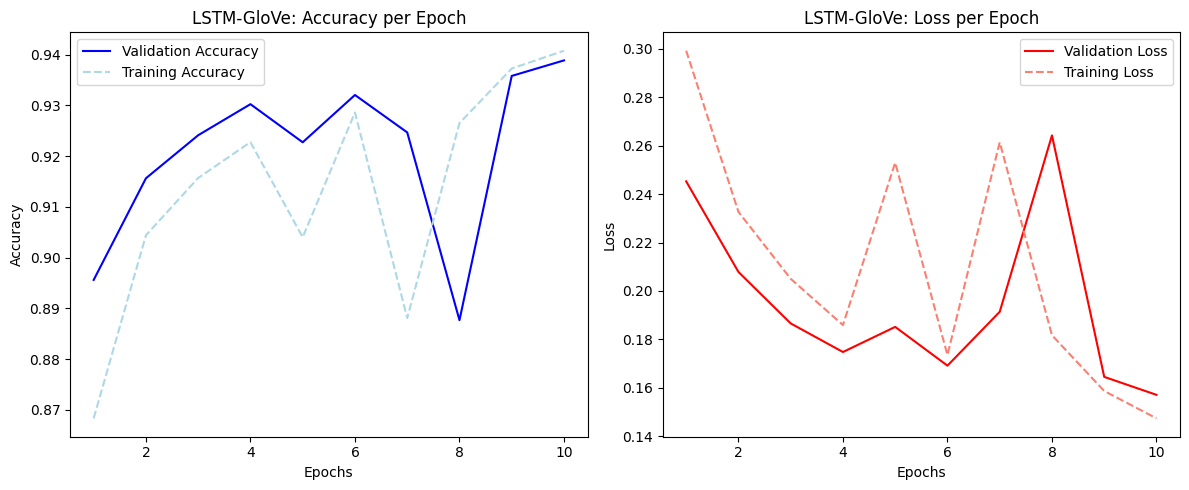

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_lstm.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history_lstm.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.plot(epochs, history_lstm.history['accuracy'], label='Training Accuracy', color='lightblue', linestyle='--')
plt.title('LSTM-GloVe: Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.plot(epochs, history_lstm.history['loss'], label='Training Loss', color='salmon', linestyle='--')
plt.title('LSTM-GloVe: Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###**6.3.2 Tiny-BERT**

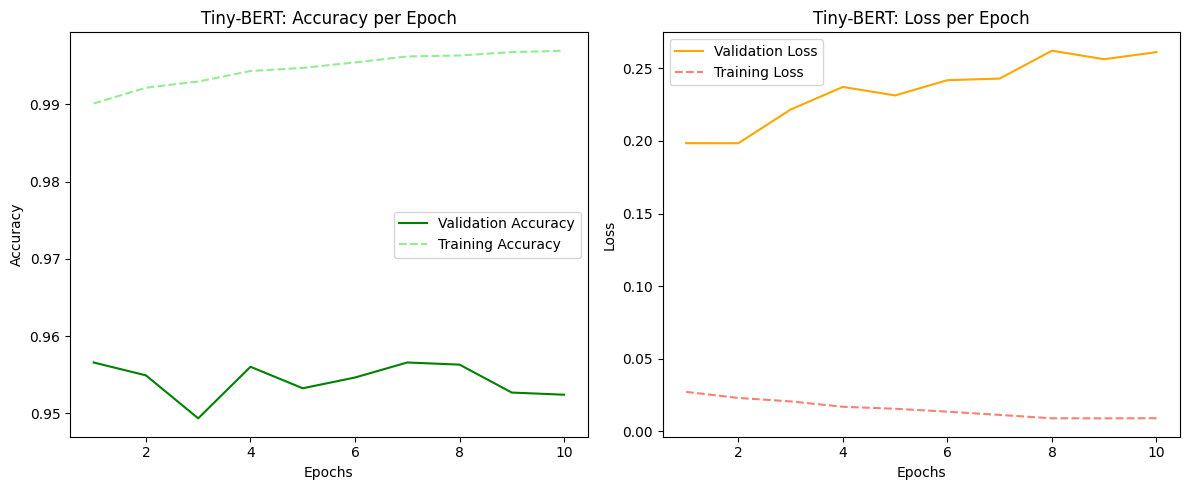

In [ ]:
import matplotlib.pyplot as plt

epochs_tiny = range(1, len(history_tiny.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_tiny, history_tiny.history["val_accuracy"], label="Validation Accuracy", color="green")
plt.plot(epochs_tiny, history_tiny.history["accuracy"], label="Training Accuracy", color="lightgreen", linestyle="--")
plt.title("Tiny-BERT: Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_tiny, history_tiny.history["val_loss"], label="Validation Loss", color="orange")
plt.plot(epochs_tiny, history_tiny.history["loss"], label="Training Loss", color="salmon", linestyle="--")
plt.title("Tiny-BERT: Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()